## Dataset
### Naver sentiment movie corpus 데이터 불러오기

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


### 데이터 전처리, 토큰화, 사전 구성

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data):
    # 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any')
    # 한글 외 문자 제거
    #train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    #test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    # 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    # 사전 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)    # 가장 빈도수 높은 9996개 토큰
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2  # unknown
    word_to_index["<UNUSED>"] = 3
    word_to_index.pop("", None)
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
X_train[:3]

[['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠',
  '.',
  '..',
  '포스터',
  '보고',
  '초딩',
  '영화',
  '줄',
  '.',
  '...',
  '오버',
  '연기',
  '조차',
  '가볍',
  '지',
  '않',
  '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

In [6]:
word_to_index['너']

625

In [7]:
len(word_to_index)

10000

In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 인코딩

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [10]:
encoded_X_train = get_encoded_sentences(X_train, word_to_index)
encoded_X_test = get_encoded_sentences(X_test, word_to_index)

In [11]:
encoded_X_train[:3]

[[1, 32, 74, 919, 4, 4, 39, 228, 20, 33, 748],
 [1,
  1028,
  4,
  11,
  519,
  549,
  687,
  5,
  120,
  4,
  70,
  1639,
  52,
  925,
  1006,
  15,
  44,
  391],
 [1, 24, 205, 2]]

#### 문장 길이 통일

In [12]:
total_data_text = list(encoded_X_train) + list(encoded_X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  16.96940191154864
문장길이 최대 :  117
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  42
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 데이터셋 분리
padding 위치에 따라 post, pre로 구분

In [13]:
import tensorflow as tf

X_train_post = tf.keras.preprocessing.sequence.pad_sequences(encoded_X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_post = tf.keras.preprocessing.sequence.pad_sequences(encoded_X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(encoded_X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(encoded_X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(X_train_post.shape)
print(X_test_post.shape)

(146182, 42)
(49157, 42)


In [14]:
# validation set 5000건 분리
X_val_post = X_train_post[:5000]   
X_val_pre = X_train_pre[:5000]   
y_val = y_train[:5000]

# validation set을 제외한 나머지
X_train_post = X_train_post[5000:]  
X_train_pre = X_train_pre[5000:]  
y_train = y_train[5000:]

print(X_train_pre.shape)
print(y_train.shape)

(141182, 42)
(141182,)


## Training

### 학습, 학습 결과 확인 함수 정의

In [15]:
import matplotlib.pyplot as plt

def train_model(model, epochs=20, 
                x_train=X_train_post, y_train=y_train, 
                x_val=X_val_post, y_val=y_val,
                x_test=X_test_post, y_test=y_test,
                use_callback=True,):
    if use_callback:
        callbacks_list = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",    # 검증 loss 모니터링
            patience=3,    # 세 번의 에포크동안 정확도 향상되지 않으면 훈련 중지
        )]
    else:
        callbacks_list = []
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        batch_size=512,
                        callbacks=callbacks_list,
                        validation_data=(x_val, y_val),
                        verbose=1)
    results = model.evaluate(x_test,  y_test, verbose=2)
    history_dict = history.history
    return history_dict

def plot_result(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, axs = plt.subplots(1,2)
    axs[0].plot(epochs, loss, 'bo', label='Training loss')
    axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(epochs, acc, 'ro', label='Training accuracy')
    axs[1].plot(epochs, val_acc, 'r', label='Validation accuracy')
    axs[1].set_title('Training and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

### 모델 생성

> 모델 선정 이유: 한국어 데이터셋과 IMDB 데이터셋 사이의 차이를 보고 싶어 학습 시 사용한 모델인 LSTM, GlobalMaxPooling1D, 1DConv를 사용했다.성능은 나쁘지 않았지만 과적합이 너무 빨리 일어나 드롭아웃을 추가하거나 층을 키우는 실험을 진행할 예정이다   


> metrics 선정 이유: 긍/부정 이진 분류 문제이므로 정확도로 충분히 측정할 수 있다  


> loss 선정 이유: 긍/부정 이진 분류 문제이므로 binary cross entropy loss가 적절하다

In [16]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기
word_vector_dim = 48   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

#### 1) LSTM

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
# LSTM은 RNN 계열이므로 앞쪽이 패딩인 데이터셋 선택
history = train_model(model, x_train=X_train_pre, x_val=X_val_pre, x_test=X_test_pre)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 48)          480000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1824      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 481,905
Trainable params: 481,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
276/276 [==============================] - 5s 7ms/step - loss: 0.5217 - accuracy: 0.7324 - val_loss: 0.3645 - val_accuracy: 0.8484
Epoch 2/20
276/276 [==============================] - 1s 5ms/step - loss: 0.3413 - accuracy: 0.8566 - val_

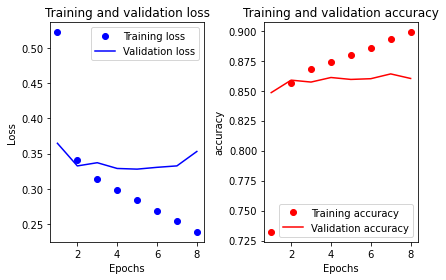

In [18]:
plot_result(history)

#### 2) GlobalMaxPooling1D

In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
history = train_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 48)          480000    
_________________________________________________________________
global_max_pooling1d (Global (None, 48)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 392       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 480,401
Trainable params: 480,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
276/276 [==============================] - 1s 4ms/step - loss: 0.5095 - accuracy: 0.8008 - val_loss: 0.3566 - val_accuracy: 0.8462
Epoch 2/20
276/276 [==============================] - 1s 3ms/step - loss: 0.3336 - accuracy: 0.8577 - va

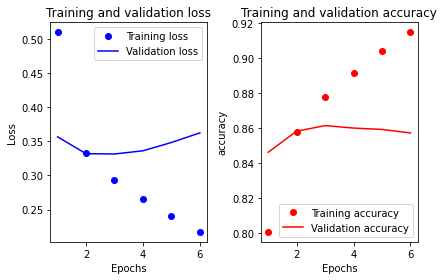

In [20]:
plot_result(history)

#### 3) 1D CNN

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
history = train_model(model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 48)          480000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          2320      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

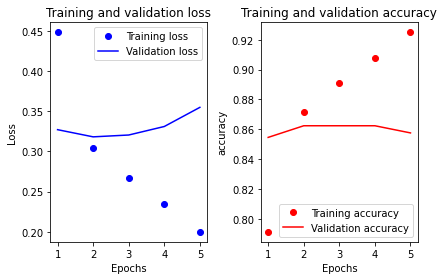

In [22]:
plot_result(history)

#### 4) 사전학습된 Word2Vec

In [23]:
import gensim
from gensim.models.word2vec import Word2Vec

자체학습한 임베딩

In [24]:
embedding_dim = 100


model = Word2Vec(  
    sentences = X_train,
    window = 5,  
    min_count = 5,  
    workers = 4,  
    sg = 0  
)
model.wv.most_similar("너")

[('넌', 0.7587099671363831),
 ('얘', 0.7144545912742615),
 ('세끼', 0.6328579187393188),
 ('새끼', 0.6286671161651611),
 ('저걸', 0.6246347427368164),
 ('ㅉㅉㅉ', 0.6240550875663757),
 ('당해', 0.6228855848312378),
 ('똑바로', 0.6172676682472229),
 ('묵', 0.6111226081848145),
 ('늬', 0.6097153425216675)]

사전학습 임베딩

In [25]:
ko_word2vec_path = '/aiffel/aiffel/sentiment_classification/models/word2vec_ko.model'
ko_model = Word2Vec.load(ko_word2vec_path)
ko_model.wv.most_similar("너")

[('제발', 0.729351282119751),
 ('아빠', 0.7095760703086853),
 ('그래', 0.7061144709587097),
 ('프레이야', 0.6787638068199158),
 ('당신', 0.6776760220527649),
 ('우린', 0.6711584329605103),
 ('넌', 0.6700929403305054),
 ('록크', 0.6657940745353699),
 ('그대', 0.6610890626907349),
 ('너희', 0.6481916308403015)]

In [26]:
# 앞에서 학습했던 모델의 임베딩 레이어를 교체하여 다시 학습
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model.wv:
        embedding_matrix[i] = ko_model.wv[index_to_word[i]]

In [27]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()
history = train_model(model)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 42, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 16)            4816      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 6, 16)             784       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

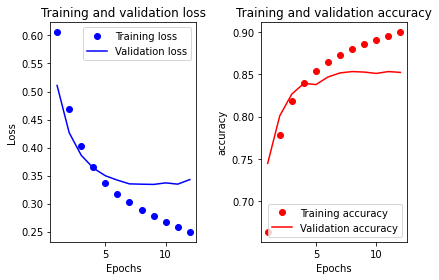

In [28]:
plot_result(history)

드롭아웃 추가

In [29]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()
history = train_model(model)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 42, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 40, 16)            4816      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6, 16)             784       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout (Dropout)            (None, 8)                

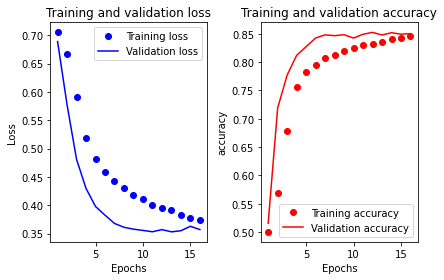

In [30]:
plot_result(history)

`LSTM`으로 레이어 변경

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
# LSTM은 RNN 계열이므로 앞쪽이 패딩인 데이터셋 선택
history = train_model(model, x_train=X_train_pre, x_val=X_val_pre, x_test=X_test_pre)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 42, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 3488      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
276/276 [==============================] - 4s 7ms/step - loss: 0.6498 - accuracy: 0.5938 - val_loss: 0.5169 - val_accuracy: 0.7606
Epoch 2/20
276/276 [==============================] - 2s 6ms/step - loss: 0.4412 - accuracy: 0.8024 

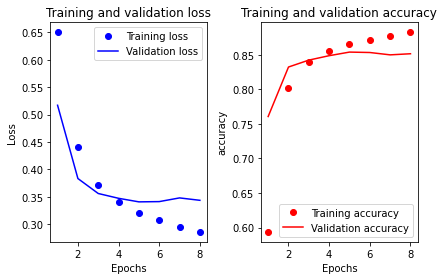

In [32]:
plot_result(history)

`GlobalMaxPooling1D`로 레이어 변경

In [33]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
history = train_model(model)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 42, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
276/276 [==============================] - 2s 4ms/step - loss: 0.8996 - accuracy: 0.5655 - val_loss: 0.6956 - val_accuracy: 0.6028
Epoch 2/20
276/276 [==============================] - 1s 4ms/step - loss: 0.6541 - accuracy: 0.6339 

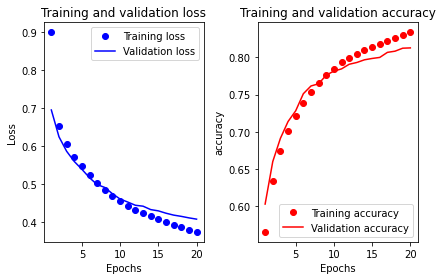

In [34]:
plot_result(history)

`LSTM`이 가장 좋은 성능을 보여줬지만 과적합이 일어났기 때문에 `LSTM`을 하나 더 쌓고 드롭아웃 추가

In [41]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(units=8, return_sequences = True))
model.add(tf.keras.layers.LSTM(units=16, return_sequences = False))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()
# LSTM은 RNN 계열이므로 앞쪽이 패딩인 데이터셋 선택
history = train_model(model, epochs=30, x_train=X_train_pre, x_val=X_val_pre, x_test=X_test_pre)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 42, 100)           1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 42, 8)             3488      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 1,005,233
Trainable params: 1,005,233
Non-trainable params: 0
___________________________________________

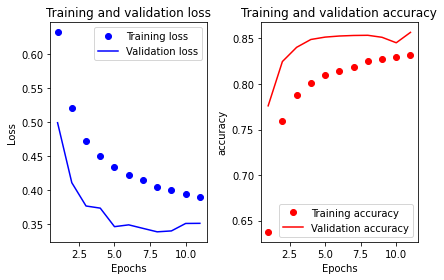

In [42]:
plot_result(history)

85% 이상 정확도 달성